In [10]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

In [11]:
import sys
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from universeg import universeg


In [12]:
model = universeg(pretrained=True)
_ = model.to(device)

In [19]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

In [15]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 48

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

Cloning into '/tmp/universeg_wbc'...


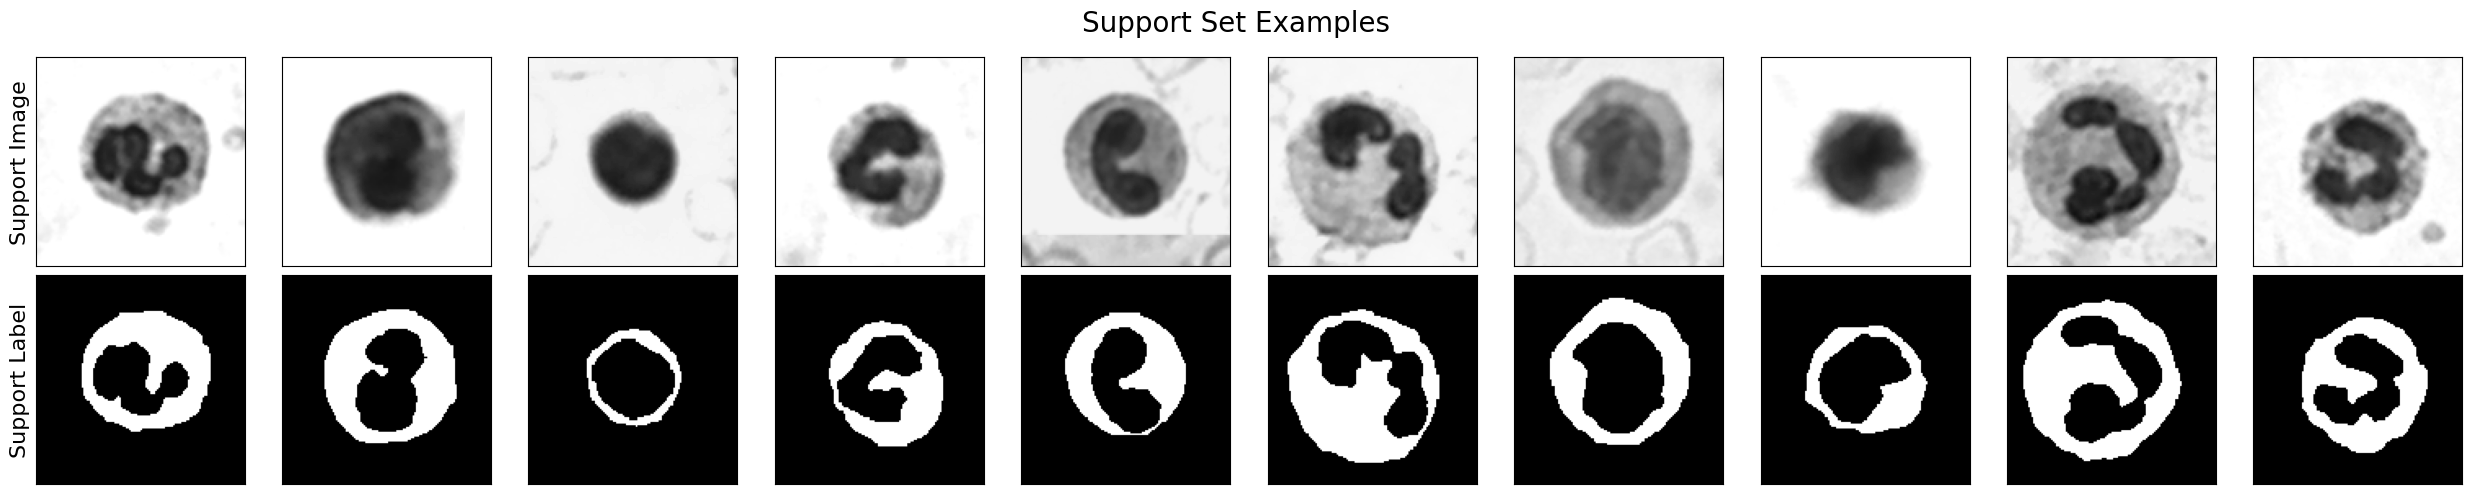

In [16]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

# Test

[W414 10:07:01.122076886 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


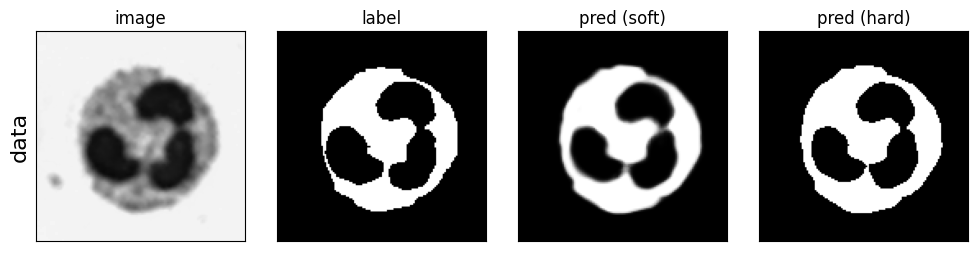

In [17]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:42<00:00, 16.21s/it]


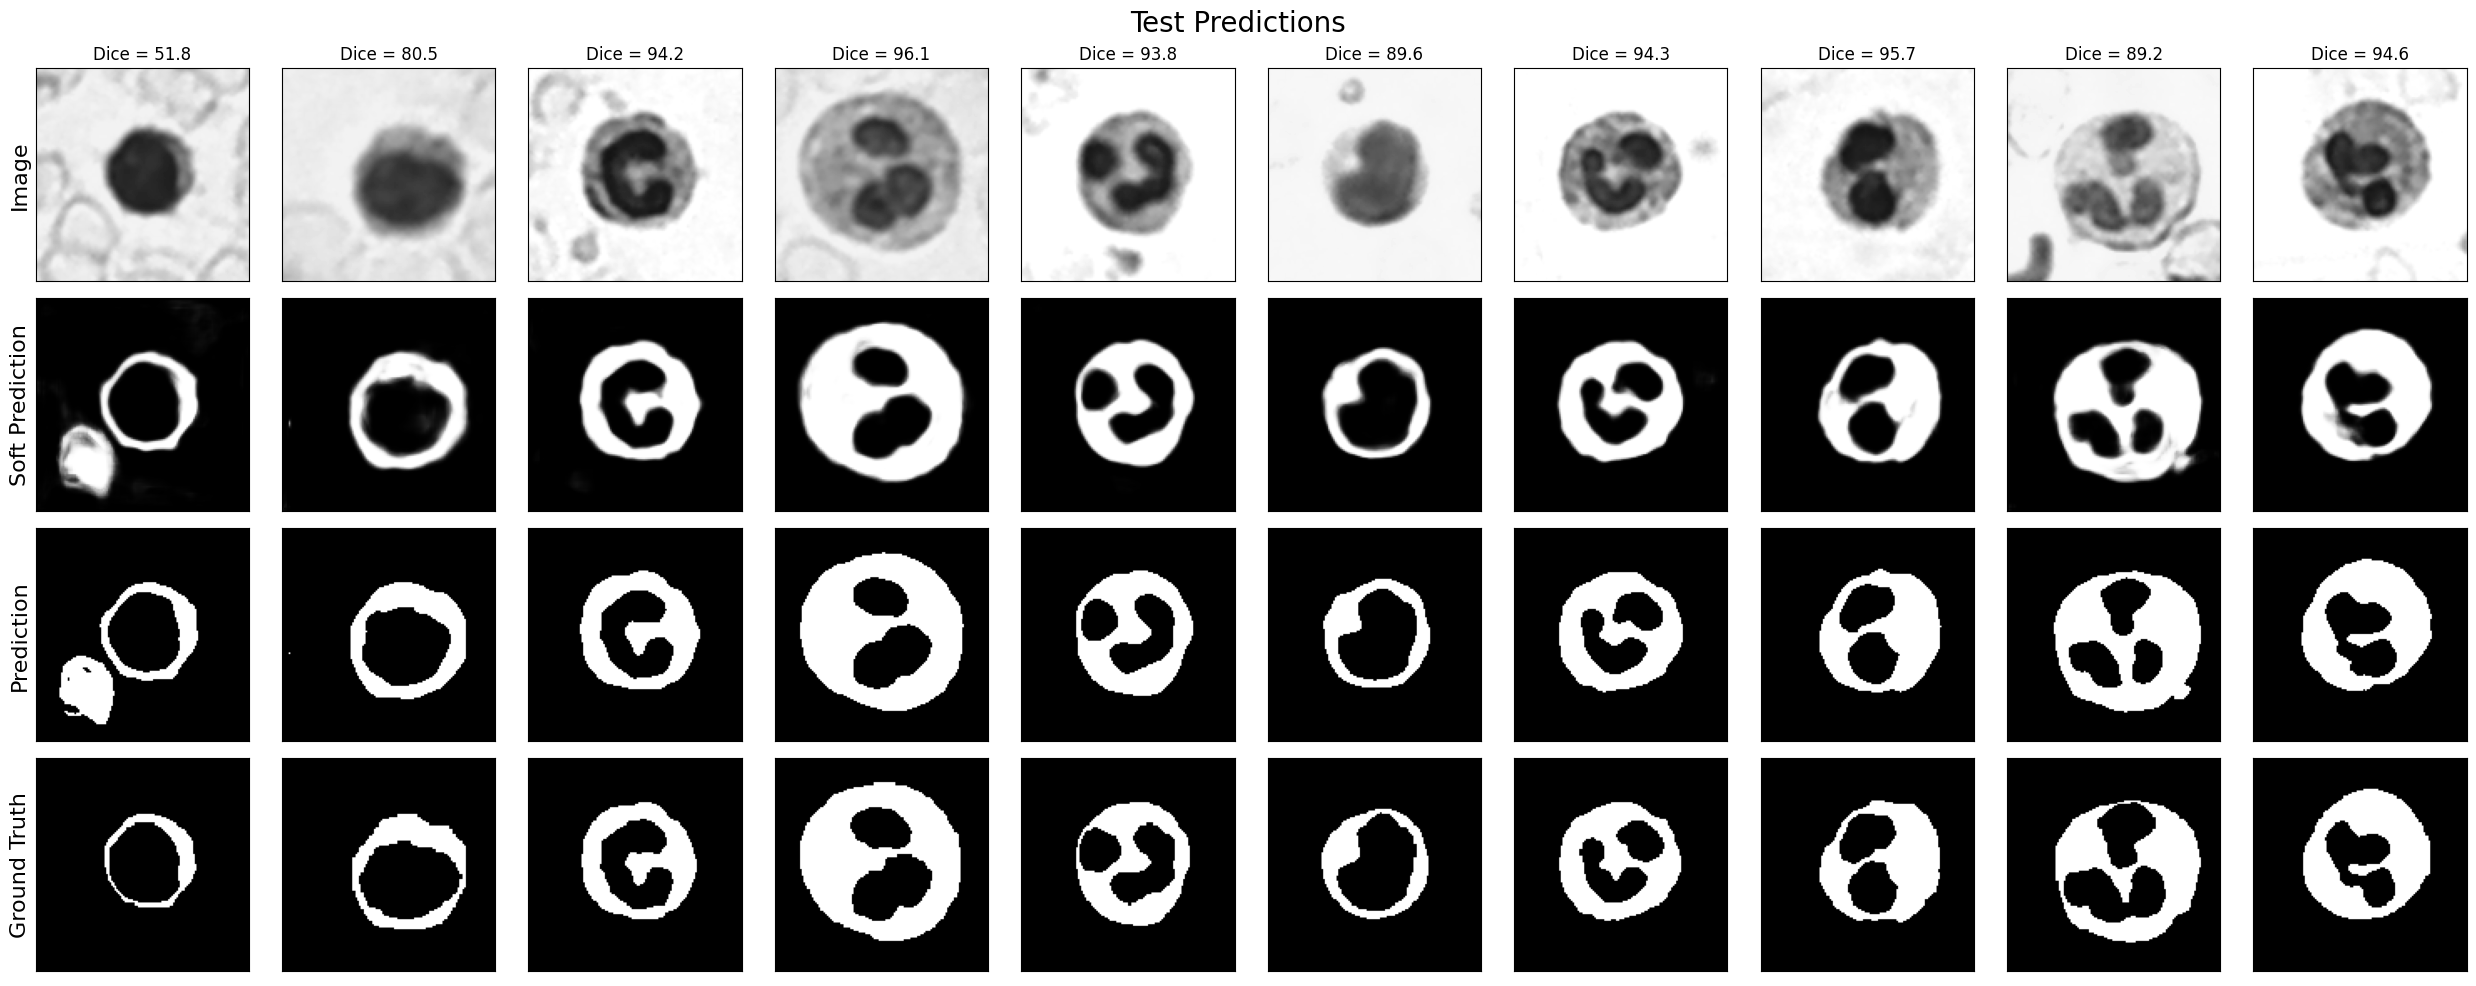

In [20]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)

Change support labels

Above, we showed results on the **cytoplasm** label in WBC.  
Here, we will show how we can easily get segmentations for another label (**nucleus**) in the same data by simply changing the support label images.

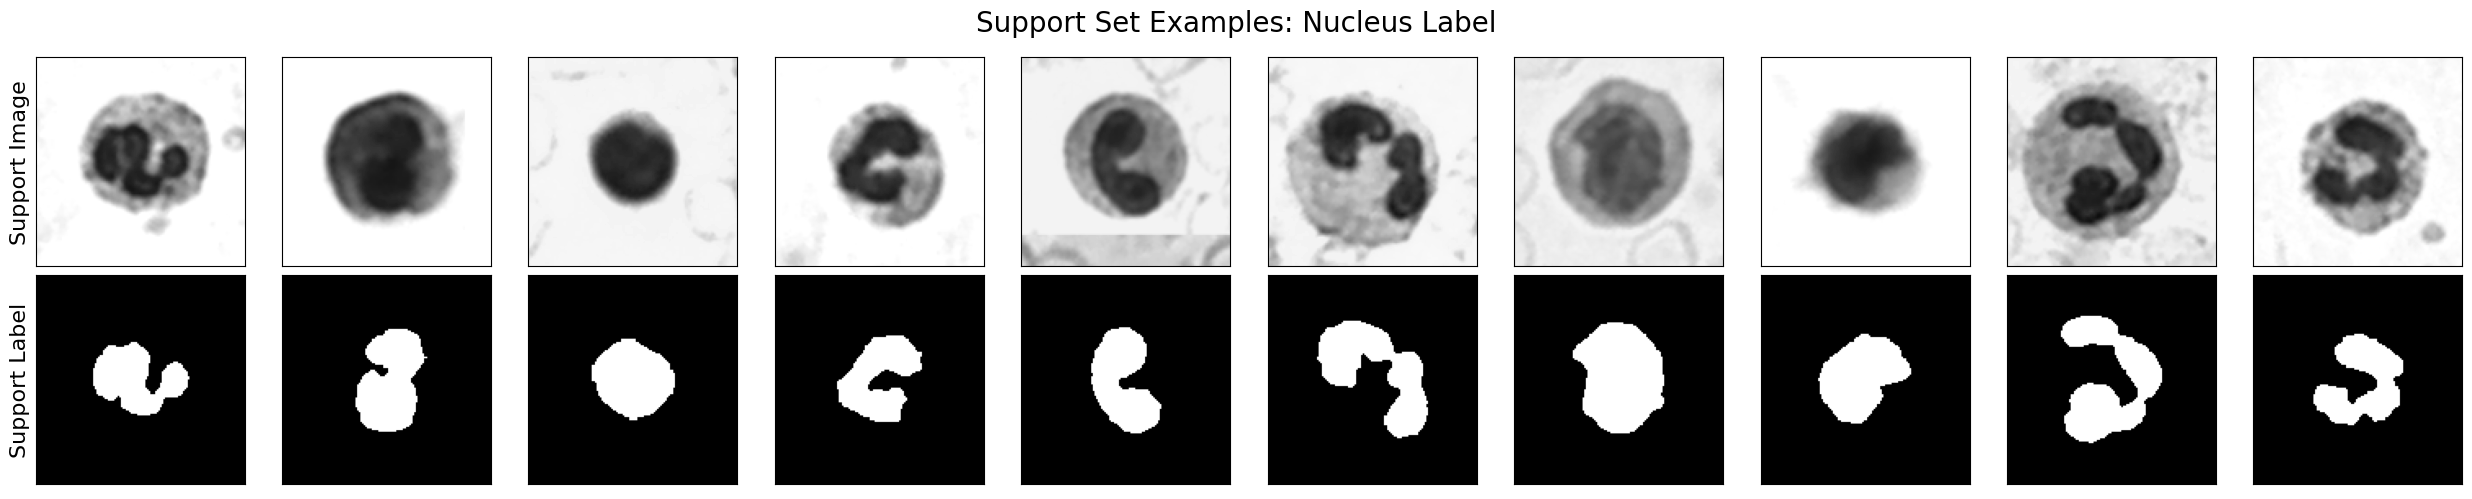

In [21]:
n_support = 64
# extract nucleus support data
d_support = WBCDataset('JTSC', split='support', label='nucleus')
d_test = WBCDataset('JTSC', split='test', label='nucleus')

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

# visualize nucleus support data
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples: Nucleus Label')

# Test

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:34<00:00, 21.50s/it]


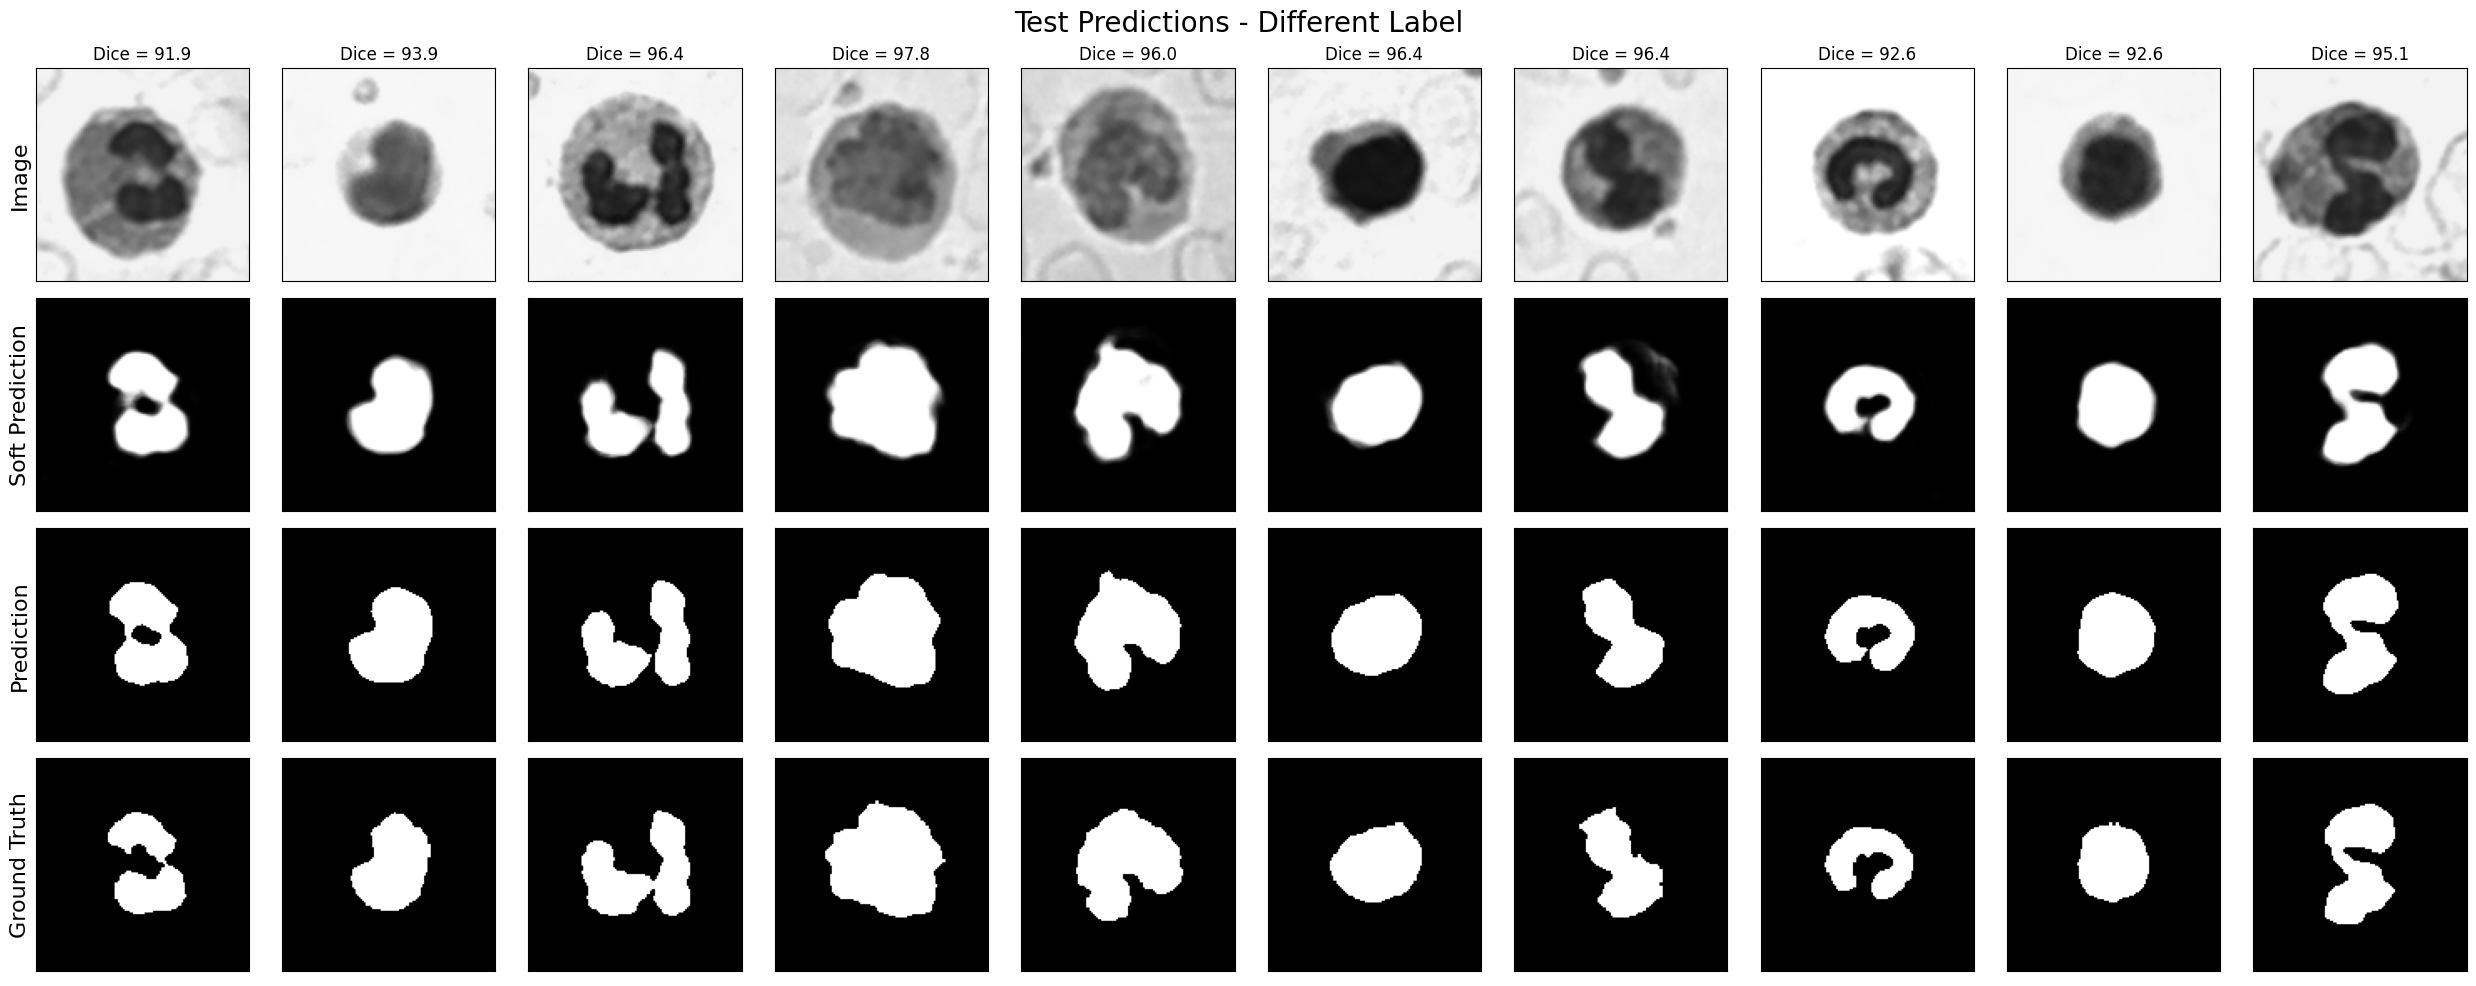

In [22]:
n_predictions = 10

results = defaultdict(list)

idxs = np.random.permutation(len(d_test))[:n_predictions]
for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Different Label', col_wrap=n_predictions)

In [32]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score
import itertools

results = []
dice_list = []
icc_list = []

def icc(mask1, mask2):
    # Flatten masks
    m1 = mask1.flatten()
    m2 = mask2.flatten()
    
    # Calculate mean-centered arrays
    mean_m1 = np.mean(m1)
    mean_m2 = np.mean(m2)
    
    ss_total = np.sum((m1 - mean_m1)**2 + (m2 - mean_m2)**2)
    ss_residual = np.sum((m1 - m2)**2)
    
    if ss_total == 0:
        return 1.0  # Identical masks
    return 1 - (ss_residual / ss_total)

def dice_coefficient(mask1, mask2):
    intersection = np.sum((mask1 == 1) & (mask2 == 1))
    volume_sum = np.sum(mask1 == 1) + np.sum(mask2 == 1)
    if volume_sum == 0:
        return 1.0
    return 2.0 * intersection / volume_sum

def compare_masks(mask1_path, mask2_path):
    # Load NIfTI files
    m1 = nib.load(mask1_path).get_fdata()
    m2 = nib.load(mask2_path).get_fdata()

    # Optional: Binarize if needed
    m1 = (m1 > 0).astype(np.uint8)
    m2 = (m2 > 0).astype(np.uint8)

    dice = dice_coefficient(m1, m2)
    icc_val = icc(m1, m2)

    return dice, icc_val


validation_folder_path = "results"
subfolders = [f.name for f in os.scandir("results") if f.is_dir()]


# folder_path = os.path.join("results", folder)

# Store Dice coefficients for each combination
dice_scores = []
for folder in subfolders:
    folder_path = os.path.join(validation_folder_path, folder)
    folder_name = os.path.basename(folder_path)
    
    mask1_path = os.path.join(folder_path, "mask.nii.gz")
    mask2_path = os.path.join(folder_path, "mask2.nii.gz")
    if not os.path.isfile(mask1_path) or not os.path.isfile(mask2_path):
        print(f"Skipping {folder} — mask not found")
        continue

    dice, icc_val = compare_masks(mask1_path, mask2_path)
    dice_list.append(dice)
    icc_list.append(icc_val)

    print(f"{folder}: Dice = {dice:.4f}, ICC = {icc_val:.4f}")

if dice_list and icc_list:
    avg_dice = sum(dice_list) / len(dice_list)
    avg_icc = sum(icc_list) / len(icc_list)
    print(f"\nOverall Dice: {avg_dice:.4f}")
    print(f"Overall ICC: {avg_icc:.4f}")
else:
    print("No valid mask pairs found for comparison.")

JAW-081_1month: Dice = 0.9111, ICC = 0.9097
JAW-076_3day: Dice = 0.8821, ICC = 0.8800
JAW-082: Dice = 0.9445, ICC = 0.9437
JAW-099_pre: Dice = 0.8804, ICC = 0.8784
JAW-093_pre: Dice = 0.9488, ICC = 0.9481
Skipping Drew — mask not found
Skipping .ipynb_checkpoints — mask not found
Skipping JAW-106_pre — mask not found
JAW-081_3day: Dice = 0.8884, ICC = 0.8866
Skipping JAW-106_3day — mask not found
JAW-097_pre: Dice = 0.9393, ICC = 0.9383
JAW-101_pre: Dice = 0.9343, ICC = 0.9334
JAW-076_pre: Dice = 0.8862, ICC = 0.8842
JAW-081_pre: Dice = 0.8723, ICC = 0.8702
JAW-096_pre: Dice = 0.9401, ICC = 0.9393
Skipping JAW-106_3month — mask not found
JAW-076_6month: Dice = 0.8721, ICC = 0.8697
JAW-081_6month: Dice = 0.8688, ICC = 0.8665
JAW-081_3month: Dice = 0.8780, ICC = 0.8759
JAW-076_1month: Dice = 0.8776, ICC = 0.8754
JAW-096_post: Dice = 0.9410, ICC = 0.9402
Skipping JAW-106_1month — mask not found

Overall Dice: 0.9040
Overall ICC: 0.9025
